# Three prime end positions:

Estimating the genic features where nanopore alignment 3' ends fall

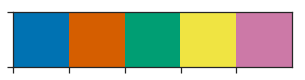

In [2]:
import sys
import re
import os
from glob import glob
from collections import Counter, namedtuple, defaultdict
from operator import add
from functools import reduce
import itertools as it
import heapq
from operator import attrgetter
import random

import numpy as np
import pandas as pd
from scipy import stats, signal
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import matplotlib_venn as vn
from matplotlib.colors import ListedColormap
import seaborn as sns

import pysam
import pyBigWig as pybw
import pybedtools as pybt

## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [2]:
def parse_exons_introns_flank(record, flanksize=200):
    start = int(record[1])
    end = int(record[2])
    exstarts = np.fromstring(record[11], sep=',') + start
    exends = exstarts + np.fromstring(record[10], sep=',')
    exons = np.dstack([exstarts, exends])[0]
    left_flank = np.array([[max(0, start - flanksize), start]])
    right_flank = np.array([[end, end + flanksize]])
    if len(exons) > 1:
        introns = np.dstack([exons[:-1, 1], exons[1:, 0]])[0]
    else:
        introns = np.array([])
    return exons, introns, left_flank, right_flank


def split_intervals(invs, pos, side='left'):
    idx = np.searchsorted(invs.ravel(), pos)
    split = np.insert(invs.ravel(), idx, [pos, pos]).reshape(-1, 2)
    split_idx = (idx + 1) // 2
    return split[:split_idx], split[split_idx:]


def parse_cds_utr_introns_flank(record, flanksize):
    exons, introns, left_flank, right_flank = parse_exons_introns_flank(record, flanksize)
    cds_start = int(record[6])
    cds_end = int(record[7])
    if not cds_start == cds_end:
        utr1, cds = split_intervals(exons, cds_start)
        cds, utr2 = split_intervals(cds, cds_end)
    else:
        utr1 = np.array([])
        cds = np.array([])
        utr2 = np.array([])
    return utr1, cds, utr2, introns, left_flank, right_flank, exons


def parse_features(record, flanksize=500):
    features = {}
    invs = {}
    features['chrom'] = record[0].replace('Chr', '')
    features['strand'] = record[5]
    features['gene_id'] = record[3]
    utr1, invs['cds'], utr2, invs['introns'], left_flank, right_flank, invs['exons'] = parse_cds_utr_introns_flank(record, flanksize)
    if features['strand'] == '+':
        invs['5utr'] = utr1
        invs['3utr'] = utr2
        invs['upstream'] = left_flank
        invs['downstream'] = right_flank
    else:
        invs['5utr'] = utr2
        invs['3utr'] = utr1
        invs['upstream'] = right_flank
        invs['downstream'] = left_flank
    features['invs'] = invs
    return features


def get_lengths_for_norm():
    feat_lengths = Counter()
    with open(genes_bed) as bed:
        for record in bed:
            record = parse_features(record.split())
            if record['chrom'] in ['C', 'M']:
                continue
            for feat_type, invs in record['invs'].items():
                for inv in invs:
                    feat_lengths[feat_type] += (inv[1] - inv[0])
    return pd.Series(feat_lengths) / 1000


def intersect(inv_a, inv_b):
    a_start, a_end = inv_a
    b_start, b_end = inv_b
    if a_end < b_start or a_start > b_end:
        return 0
    else:
        s = max(a_start, b_start)
        e = min(a_end, b_end)
        return e - s


def intersect_spliced_invs(invs_a, invs_b):
    score = 0
    invs_a = iter(invs_a)
    invs_b = iter(invs_b)
    a_start, a_end = next(invs_a)
    b_start, b_end = next(invs_b)
    while True:
        if a_end < b_start:
            try:
                a_start, a_end = next(invs_a)
            except StopIteration:
                break
        elif a_start > b_end:
            try:
                b_start, b_end = next(invs_b)
            except StopIteration:
                break
        else:
            score += intersect([a_start, a_end], [b_start, b_end])
            if a_end > b_end:
                try:
                    b_start, b_end = next(invs_b)
                except StopIteration:
                    break
            else:
                try:
                    a_start, a_end = next(invs_a)
                except StopIteration:
                    break
    return score


class MultiBam(object):

    def __init__(self, bam_fns):
        self.bam_handles = {bam_fn: pysam.AlignmentFile(bam_fn) for bam_fn in bam_fns}
        self.closed = False

    def fetch(self, *args, **kwargs):
        queries = [bam.fetch(*args, **kwargs) for bam in self.bam_handles.values()]
        yield from heapq.merge(*queries, key=attrgetter('reference_start'))

    def close(self):
        for bam in self.bam_handles.values():
            bam.close()

    def __enter__(self):
        return self

    def __exit__(self, *args):
        self.close()



def bam_cigar_to_invs(aln, max_allowed_insertion):
    invs = []
    start = aln.reference_start
    end = aln.reference_end
    strand = '-' if aln.is_reverse else '+'
    left = start
    right = left
    has_ins = False
    for op, ln in aln.cigar:
        if op in (4, 5):
            # does not consume reference
            continue
        elif op == 1 and ln > max_allowed_insertion:
            has_ins = True
        elif op in (0, 2, 7, 8):
            # consume reference but do not add to invs yet
            right += ln
        elif op == 3:
            invs.append([left, right])
            left = right + ln
            right = left
    if right > left:
        invs.append([left, right])
    assert invs[0][0] == start
    assert invs[-1][1] == end
    return start, end, strand, np.array(invs), has_ins


PARSED_ALN = namedtuple('Aln', 'chrom start end read_id strand invs')

def parse_pysam_aln(aln, max_allowed_insertion):
    chrom = aln.reference_name
    read_id = aln.query_name
    start, end, strand, invs, has_ins = bam_cigar_to_invs(
        aln, max_allowed_insertion)
    return PARSED_ALN(chrom, start, end, read_id, strand, invs), has_ins


def assign_three_prime_to_feature(three_prime_end, bed_record):
    if bed_record['strand'] == '+' and three_prime_end >= bed_record['invs']['exons'][-1][1]:
        return 'downstream'
    elif bed_record['strand'] == '-' and three_prime_end < bed_record['invs']['exons'][0][0]:
        return 'downstream'
    for feature_type in ['3utr', 'cds', 'introns', '5utr']:
        invs = bed_record['invs'][feature_type]
        for start, end in invs:
            if start <= three_prime_end < end:
                return feature_type
    else:
        assert False


def count_three_prime_ends_in_features(annotation_bed_fn, bam_fns):
    feature_pos_counts = defaultdict(Counter)
    feature_read_counts = defaultdict(Counter)
    with open(annotation_bed_fn) as bed, MultiBam(bam_fns) as bam:
        for record in bed:
            record = parse_features(record.split())
            gene_tpe = Counter()
            if not len(record['invs']['cds']):
                # not protein coding, continue:
                continue
            record_span = (record['invs']['exons'][0][0], record['invs']['exons'][-1][1])
            for aln in bam.fetch(record['chrom'], *record_span):
                aln, has_ins = parse_pysam_aln(aln, 30)
                if has_ins:
                    continue
                elif aln.strand != record['strand']:
                    continue
                aln_len = sum([e - s for s, e in aln.invs])
                i = intersect_spliced_invs(aln.invs, record['invs']['exons'])
                if i / aln_len > 0.2:
                    tpe = aln.start if aln.strand == '-' else aln.end
                    gene_tpe[tpe] += 1
            for tpe, count in gene_tpe.items():
                feat_type = assign_three_prime_to_feature(tpe, record)
                feature_pos_counts[record['gene_id']][feat_type] += 1
                feature_read_counts[record['gene_id']][feat_type] += count
    feature_pos_counts = pd.DataFrame.from_dict(feature_pos_counts, orient='index').fillna(0)
    feature_read_counts = pd.DataFrame.from_dict(feature_read_counts, orient='index').fillna(0)
    return feature_pos_counts, feature_read_counts

In [184]:
ARAPORT = '/cluster/ggs_lab/mtparker/Arabidopsis_annotations/Araport/v11/201606/Araport11_GFF3_genes_transposons.flat_genes.bed'

three_prime_pos_counts, three_prime_read_counts = count_three_prime_ends_in_features(
    ARAPORT,
    glob('../chimeric_transcripts/vir1_vs_col0/aligned_data/201*_col0_*.bam') + \
    ['/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/20180411_1432_20180911_FAH84603_5adapterLIG_Col0_2916/aligned_data/TAIR10/201902_col0_2916_5adapter_exp2.bam',
     '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/20180508_1522_20180508_FAH82422_5adapt_lig_mRNA_2918/aligned_data/TAIR10/201902_col0_2918_5adapter.bam']
)

In [185]:
three_prime_read_counts.sum(0)

3utr          4026196.0
downstream     126604.0
cds            108878.0
introns         12554.0
5utr            10646.0
dtype: float64

In [196]:
three_prime_pos_counts.sum(0)

3utr          594714.0
downstream     44464.0
cds            38055.0
introns         7791.0
5utr            1555.0
dtype: float64

In [198]:
three_prime_read_counts.head()

,3utr,downstream,cds,introns,5utr
AT1G01010,7.0,1.0,0.0,0.0,0.0
AT1G01020,52.0,2.0,10.0,1.0,0.0
AT1G01030,2.0,7.0,0.0,0.0,0.0
AT1G01040,29.0,2.0,2.0,0.0,0.0
AT1G01050,257.0,10.0,4.0,2.0,0.0


In [209]:
tot = three_prime_read_counts.sum(0)
(tot['3utr'] + tot['downstream']) / tot.sum() * 100

96.91757851682125

In [210]:
tot['3utr'] + tot['downstream']

4152800.0

In [211]:
(tot['cds'] + tot['5utr']) / tot.sum()  * 100

2.7894376455992447

In [212]:
(tot['cds'] + tot['5utr'])

119524.0

In [213]:
(tot['introns']) / tot.sum() * 100

0.29298383757950636

In [214]:
tot = three_prime_pos_counts.sum(0)
(tot['3utr'] + tot['downstream']) / tot.sum() * 100

93.09606032226444

In [215]:
tot['3utr'] + tot['downstream']

639178.0

In [216]:
(tot['cds'] + tot['5utr']) / tot.sum()  * 100

5.769183152994776

In [217]:
(tot['cds'] + tot['5utr'])

39610.0

In [218]:
(tot['introns']) / tot.sum() * 100

1.13475652474078

In [334]:
tot['introns']

7791.0

In [194]:
three_prime_counts = three_prime_counts.assign(total=three_prime_counts[['downstream', '3utr', 'cds', 'introns', '5utr']].sum(1))
three_prime_counts = three_prime_counts.assign(
    downstream_or_3utr_percent=(three_prime_counts.downstream + three_prime_counts['3utr']) / three_prime_counts.total * 100,
    before_3utr_percent=(three_prime_counts.cds + three_prime_counts.introns + three_prime_counts['5utr']) / three_prime_counts.total * 100,
    utr5_percent=three_prime_counts['5utr'] / three_prime_counts.total * 100,
    cds_percent=three_prime_counts['cds'] / three_prime_counts.total * 100,
    introns_percent=three_prime_counts['introns'] / three_prime_counts.total * 100,
)
three_prime_counts.head()

,downstream,3utr,cds,introns,5utr,total,downstream_or_3utr_percent,before_3utr_percent,utr5_percent,cds_percent,introns_percent
AT1G01010,3.0,7.0,0.0,0.0,0.0,10.0,100.000000,0.000000,0.0,0.000000,0.000000
AT1G01020,2.0,85.0,8.0,1.0,0.0,96.0,90.625000,9.375000,0.0,8.333333,1.041667
AT1G01030,12.0,6.0,0.0,0.0,0.0,18.0,100.000000,0.000000,0.0,0.000000,0.000000
AT1G01040,4.0,42.0,2.0,0.0,0.0,48.0,95.833333,4.166667,0.0,4.166667,0.000000
AT1G01050,26.0,354.0,3.0,0.0,0.0,383.0,99.216710,0.783290,0.0,0.783290,0.000000


In [254]:
three_prime_counts.head()

,downstream,3utr,cds,introns,5utr,total,downstream_or_3utr_percent,before_3utr_percent,utr5_percent,cds_percent,introns_percent
AT1G01010,3.0,7.0,0.0,0.0,0.0,10.0,100.000000,0.000000,0.0,0.000000,0.000000
AT1G01020,2.0,85.0,8.0,1.0,0.0,96.0,90.625000,9.375000,0.0,8.333333,1.041667
AT1G01030,12.0,6.0,0.0,0.0,0.0,18.0,100.000000,0.000000,0.0,0.000000,0.000000
AT1G01040,4.0,42.0,2.0,0.0,0.0,48.0,95.833333,4.166667,0.0,4.166667,0.000000
AT1G01050,26.0,354.0,3.0,0.0,0.0,383.0,99.216710,0.783290,0.0,0.783290,0.000000


In [255]:
three_prime_counts.to_excel(
    'nanopore_three_prime_end_position_counts.xlsx',
    sheet_name='three_prime_end_positions'
)